# Binary Classification: Benign vs Malignant

This notebook performs complete binary classification pipeline:
1. **Preprocess Data** - Load and prepare images
2. **Train Model** - Build and train SVM classifier
3. **Evaluate Model** - Assess performance with metrics

---

## Step 1: Preprocess Data

In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve
)
from image_loader import (
    load_images_from_metadata, verify_image_metadata_match,
    get_image_path, load_and_preprocess_image
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load metadata
metadata_path = '../data/HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

print(f"Metadata loaded: {df.shape[0]} samples")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Metadata loaded: 10015 samples

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# Create binary labels
# Malignant: mel, bcc, akiec, vasc
# Benign: nv, df, bkl

malignant_types = ['mel', 'bcc', 'akiec', 'vasc']
benign_types = ['nv', 'df', 'bkl']

df['binary_label'] = df['dx'].apply(lambda x: 1 if x in malignant_types else 0)
df['binary_class'] = df['binary_label'].map({0: 'Benign', 1: 'Malignant'})

print("Binary labels created:")
print(df['binary_class'].value_counts())
print(f"\nClass balance: {df['binary_label'].value_counts()[0] / df['binary_label'].value_counts()[1]:.2f}:1 (Benign:Malignant)")

Binary labels created:
binary_class
Benign       7919
Malignant    2096
Name: count, dtype: int64

Class balance: 3.78:1 (Benign:Malignant)


In [4]:
# Load images (this may take a few minutes)
print("Loading images... This may take several minutes.")
print("=" * 60)

IMAGE_SIZE = (224, 224)
images, loaded_image_ids = load_images_from_metadata(
    df,
    base_path='../data',
    target_size=IMAGE_SIZE,
    normalize=True,
    verbose=True
)

print(f"\nLoaded images shape: {images.shape}")
print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Memory usage: {images.nbytes / (1024**3):.2f} GB")

Loading images... This may take several minutes.
Loaded 1000/10015 images...
Loaded 2000/10015 images...
Loaded 3000/10015 images...
Loaded 4000/10015 images...
Loaded 5000/10015 images...
Loaded 6000/10015 images...
Loaded 7000/10015 images...
Loaded 8000/10015 images...
Loaded 9000/10015 images...
Loaded 10000/10015 images...

Successfully loaded: 10015/10015 images

Loaded images shape: (10015, 224, 224, 3)
Value range: [0.000, 1.000]
Memory usage: 5.62 GB


In [5]:
# Filter metadata to match loaded images
df_filtered = df[df['image_id'].isin(loaded_image_ids)].reset_index(drop=True)
y_binary = df_filtered['binary_label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print("Train-Test Split:")
print(f"Training: {X_train.shape}")
print(f"Testing: {X_test.shape}")
print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {'Benign' if label == 0 else 'Malignant'}: {count} ({count/len(y_train)*100:.1f}%)")

Train-Test Split:
Training: (8012, 224, 224, 3)
Testing: (2003, 224, 224, 3)

Training class distribution:
  Benign: 6335 (79.1%)
  Malignant: 1677 (20.9%)


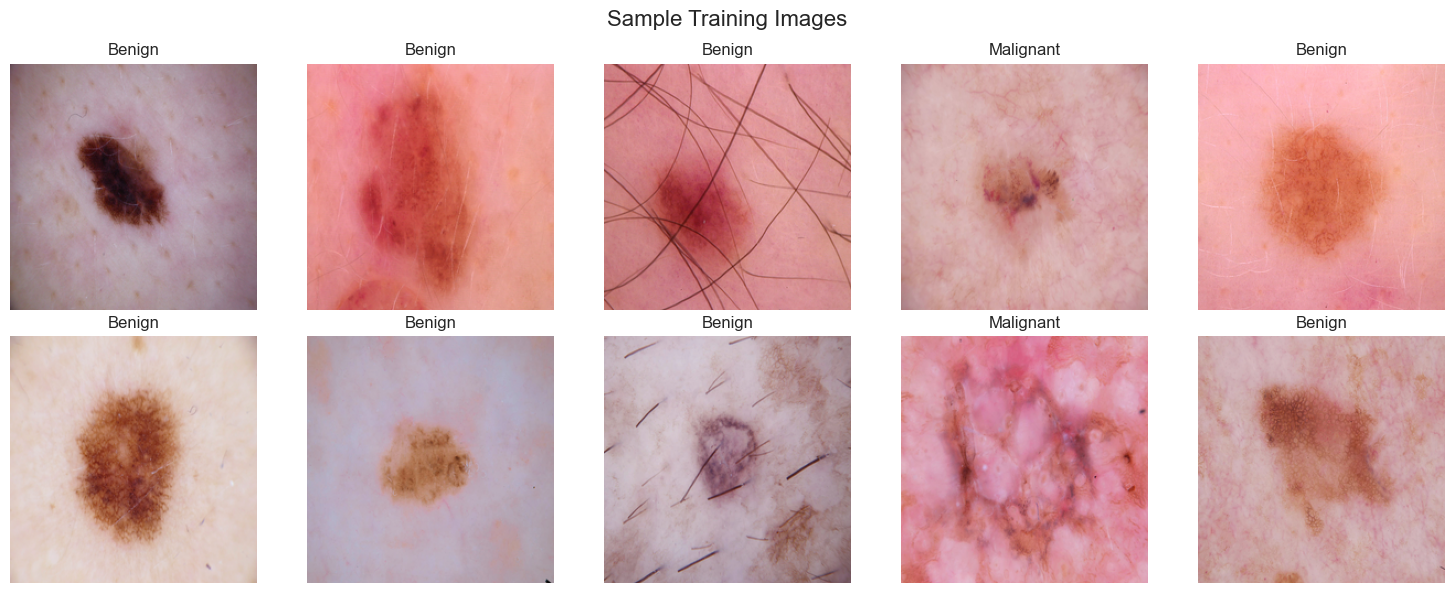

Data preprocessing complete!


In [6]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Training Images', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[i])
    label = 'Malignant' if y_train[i] == 1 else 'Benign'
    ax.set_title(f"{label}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Data preprocessing complete!")

## Step 2: Train Model

In [7]:
# Flatten images for SVM (SVM requires 2D input)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data: {X_train_flat.shape}")
print(f"Flattened testing data: {X_test_flat.shape}")

Flattened training data: (8012, 150528)
Flattened testing data: (2003, 150528)


In [8]:
# Initialize SVM model
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'
)

print("SVM Model Configuration:")
print(f"  Kernel: {svm_model.kernel}")
print(f"  C: {svm_model.C}")
print(f"  Gamma: {svm_model.gamma}")
print(f"  Class Weight: {svm_model.class_weight}")

SVM Model Configuration:
  Kernel: rbf
  C: 1.0
  Gamma: scale
  Class Weight: balanced


In [ ]:
# Train the model
import time

print("Training SVM model...")
start_time = time.time()

svm_model.fit(X_train_flat, y_train)

training_time = time.time() - start_time

print(f"Training complete! Time: {training_time:.2f} seconds")
print(f"Number of support vectors: {svm_model.n_support_}")

Training SVM model...


In [ ]:
# Make predictions
y_train_pred = svm_model.predict(X_train_flat)
y_test_pred = svm_model.predict(X_test_flat)
y_test_proba = svm_model.predict_proba(X_test_flat)[:, 1]

print("Predictions complete!")
print(f"\nSample predictions (first 10):")
for i in range(10):
    true_label = 'Malignant' if y_test[i] == 1 else 'Benign'
    pred_label = 'Malignant' if y_test_pred[i] == 1 else 'Benign'
    match = "✓" if y_test[i] == y_test_pred[i] else "✗"
    print(f"  {match} True: {true_label:10s} | Predicted: {pred_label:10s} | Prob: {y_test_proba[i]:.3f}")

## Step 3: Evaluate Model

In [ ]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 50)
print("ACCURACY SCORES")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

accuracy_diff = train_accuracy - test_accuracy
if accuracy_diff > 0.05:
    print(f"\nWarning: Possible overfitting (diff: {accuracy_diff:.4f})")
else:
    print(f"\nModel generalizes well (diff: {accuracy_diff:.4f})")

In [ ]:
# Confusion matrix
os.makedirs('../results', exist_ok=True)

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/binary_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Extract metrics
TN, FP, FN, TP = cm_test.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {TN} - Correctly predicted Benign")
print(f"False Positives (FP): {FP} - Benign predicted as Malignant")
print(f"False Negatives (FN): {FN} - Malignant predicted as Benign (CRITICAL)")
print(f"True Positives (TP):  {TP} - Correctly predicted Malignant")

In [ ]:
# Classification report
print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)

report = classification_report(
    y_test,
    y_test_pred,
    target_names=['Benign', 'Malignant'],
    digits=4
)
print(report)

# Calculate medical metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

print("\nMedical Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f} - Ability to detect malignant")
print(f"Specificity:          {specificity:.4f} - Ability to detect benign")
print(f"Precision (PPV):      {precision:.4f} - Accuracy of malignant predictions")

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../results/binary_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

In [ ]:
# Save model
os.makedirs('../models', exist_ok=True)

with open('../models/svm_binary_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

metrics = {
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'roc_auc': roc_auc,
    'confusion_matrix': cm_test,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'training_time': training_time
}

with open('../models/svm_binary_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Model and metrics saved successfully!")

In [ ]:
# Final Summary
print("=" * 60)
print("BINARY CLASSIFICATION - FINAL SUMMARY")
print("=" * 60)
print(f"\nModel: Support Vector Machine (SVM)")
print(f"Training Time: {training_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  ROC-AUC Score:     {roc_auc:.4f}")
print(f"\nMedical Metrics:")
print(f"  Sensitivity: {sensitivity:.4f} - {sensitivity*100:.1f}% malignant cases detected")
print(f"  Specificity: {specificity:.4f} - {specificity*100:.1f}% benign cases detected")
print(f"\nCritical Analysis:")
print(f"  False Negatives: {FN} - Missed malignant cases (CRITICAL)")
print(f"  False Positives: {FP} - Unnecessary concerns")
print("\n" + "=" * 60)
print("BINARY CLASSIFICATION COMPLETE!")
print("=" * 60)